In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

# Set Parameters
d = 5  # Depth of the tree
B = 10  # Scaling factor for the value
tau = d / 5  # Tau for the value function, depends on tree depth
iterations = 50  # Number of MCTS iterations
rollouts_per_leaf = 5  # Number of rollouts per leaf node

In [2]:
# Helper function to compute edit distance between two addresses
def edit_distance(a, b):
    return sum(1 for i in range(len(a)) if a[i] != b[i])


In [3]:
class Tree:
    def __init__(self, depth):
        self.depth = depth
        self.leaf_addresses = []
        self._generate_tree("", depth)

    def _generate_tree(self, current_address, depth):
        """Recursively generate all addresses for the binary tree"""
        if depth == 0:
            self.leaf_addresses.append(current_address)
        else:
            self._generate_tree(current_address + "L", depth - 1)
            self._generate_tree(current_address + "R", depth - 1)

In [4]:
# Compute leaf values based on the edit distance to the target address
def compute_leaf_values(leaf_addresses, target_address, B=10, tau=4):
    values = {}
    for address in leaf_addresses:
        # Compute edit distance (number of differing positions)
        edit_dist = edit_distance(address, target_address)
        # Add noise to the value
        noise = np.random.normal(0, 1)
        # Compute value as a function of edit distance
        values[address] = B * np.exp(-edit_dist / tau) + noise
    return values


In [5]:
# Node class for MCTS
class Node:
    def __init__(self, address):
        self.address = address
        self.visit_count = 0
        self.value_sum = 0
        self.children = {}

    def ucb_score(self, total_visits, c):
        if self.visit_count == 0:
            return float('inf')  # High exploration value
        return (self.value_sum / self.visit_count) + c * np.sqrt(np.log(total_visits + 1) / self.visit_count)


In [11]:
def mcts(tree, leaf_values, iterations, rollouts_per_leaf, c=np.sqrt(2)):
    root = Node(address="root")  # Root node
    ucb_scores = {}
    
    # Function to select the best leaf node using UCB
    def select(node):
        """Select a leaf node using UCB"""
        path = []
        while node.children:
            path.append(node)
            best_child = None
            best_ucb = float('-inf')
            for child in node.children.values():
                # Use the UCB score from the Node class method
                ucb_score = child.ucb_score(total_visits=node.visit_count, c=c)
                ucb_scores[child.address] = {
                    "ucb_score": ucb_score,
                    "visit_count": child.visit_count
                }
                if ucb_score > best_ucb:
                    best_ucb = ucb_score
                    best_child = child
            # Move to the best child
            node = best_child
        return node, path

    # Expand a node by adding its children
    def expand(node):
        """Expand a node by adding its children and initializing UCB scores."""
        if len(node.address) < tree.depth:
            left_child = Node(address=node.address + "L")
            right_child = Node(address=node.address + "R")
            node.children["L"] = left_child
            node.children["R"] = right_child
            
            ucb_scores[left_child.address] = {"ucb_score": 0.0, "visit_count": 0}
            ucb_scores[right_child.address] = {"ucb_score": 0.0, "visit_count": 0}

    # Perform a rollout (random simulation)
    def rollout(node):
        """Perform rollouts and return the average leaf value."""
        values = []
        for _ in range(rollouts_per_leaf):
            values.append(leaf_values.get(node.address, 0) + np.random.uniform(-0.5, 0.5))  # Add noise
        return np.mean(values)

    # Backpropagate the result of the rollout
    def backpropagate(path, value):
        for node in reversed(path):
            node.visit_count += 1
            node.value_sum += value

    # Ensure the root node is expanded before starting MCTS
    expand(root)

    # Main MCTS loop
    for _ in range(iterations):
        leaf, path = select(root)
        
        # Expand the leaf if necessary
        if not leaf.children and len(leaf.address) < tree.depth:
            expand(leaf)
        
        # Rollout from the leaf node
        value = rollout(leaf)
        
        # Backpropagate the result
        backpropagate(path + [leaf], value)

    # Return the best child from the root
    if root.children:
        best_child = max(root.children.values(), key=lambda child: child.value_sum / max(child.visit_count, 1))
        return best_child.address, ucb_scores
    else:
        print("Error: Root has no children!")
        return None, ucb_scores

In [13]:
def visualize_tree(tree, ucb_scores):
    """Visualize the binary tree and highlight the target and snowcap nodes"""
    G = nx.DiGraph()
    
    # Add nodes and edges for the tree
    for address in tree.leaf_addresses:
        for i in range(len(address)):
            parent = address[:i]
            child = address[:i+1]
            G.add_edge(parent, child)
            G.nodes[parent]['subset_key'] = len(parent)
            G.nodes[child]['subset_key'] = len(child)

    pos = nx.multipartite_layout(G, subset_key='subset_key')

    # Draw the tree
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10)

    # Annotate nodes with UCB scores and visit counts
    for node, (x, y) in pos.items():
        ucb_data = ucb_scores.get(node, {"ucb_score": 0.0, "visit_count": 0})
        plt.text(x, y + 0.03, f"UCB: {ucb_data['ucb_score']:.2f}\nVisits: {ucb_data['visit_count']}", fontsize=8, color="purple", ha="center")


UCB Scores and Visit Counts: {'rootL': {'ucb_score': 0.5327517076439434, 'visit_count': 24}, 'rootR': {'ucb_score': 0.5376307162642451, 'visit_count': 25}}
Target Address: RLRLL
Best Leaf Address Found: rootR


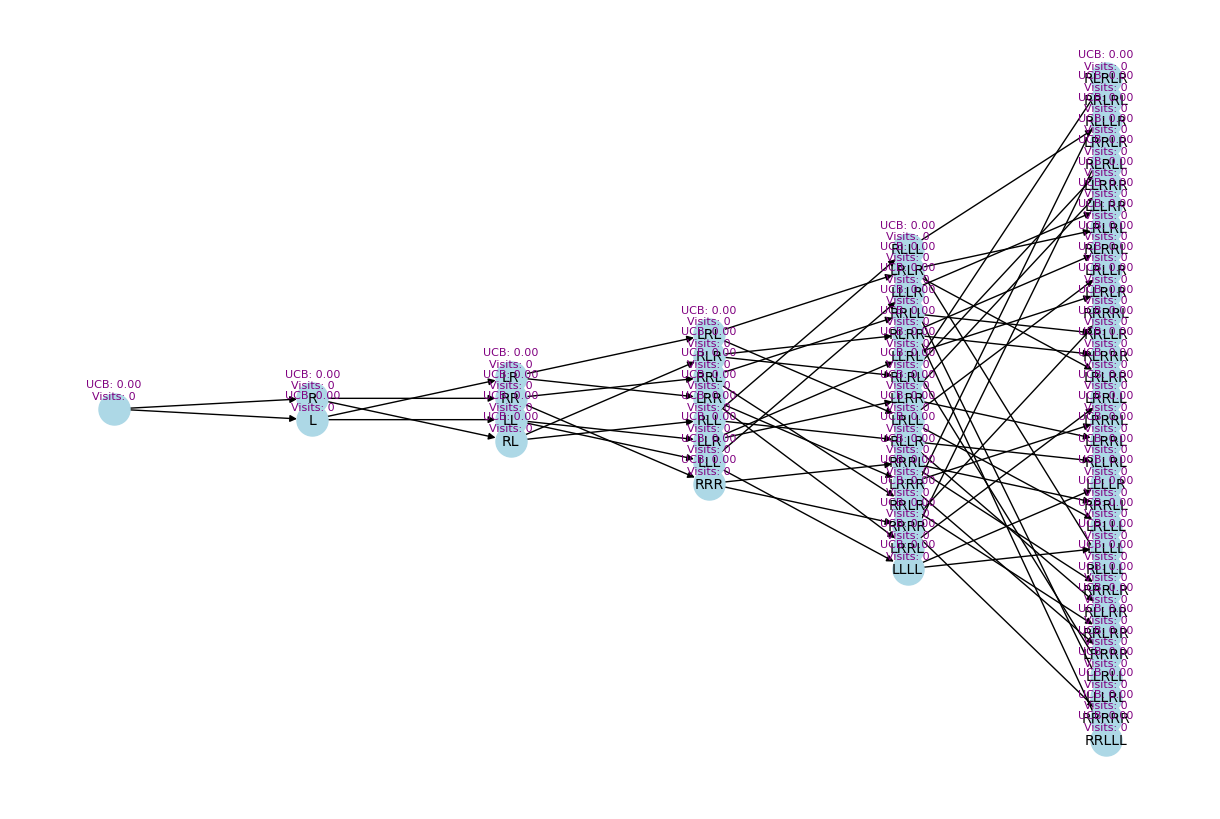

In [14]:
tree = Tree(d)
target_address = random.choice(tree.leaf_addresses)
leaf_values = compute_leaf_values(tree.leaf_addresses, target_address, B=B, tau=tau)

# Perform MCTS
best_leaf, ucb_scores = mcts(tree, leaf_values, iterations, rollouts_per_leaf)
print("UCB Scores and Visit Counts:", ucb_scores)

# Visualize the tree
visualize_tree(tree,  ucb_scores)

print("Target Address:", target_address)
print("Best Leaf Address Found:", best_leaf)